                       name  year  selling_price  km_driven    fuel  \
0             Maruti 800 AC  2007          60000      70000  Petrol   
1  Maruti Wagon R LXI Minor  2007         135000      50000  Petrol   
2      Hyundai Verna 1.6 SX  2012         600000     100000  Diesel   
3    Datsun RediGO T Option  2017         250000      46000  Petrol   
4     Honda Amaze VX i-DTEC  2014         450000     141000  Diesel   

  seller_type transmission         owner  
0  Individual       Manual   First Owner  
1  Individual       Manual   First Owner  
2  Individual       Manual   First Owner  
3  Individual       Manual   First Owner  
4  Individual       Manual  Second Owner  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   i

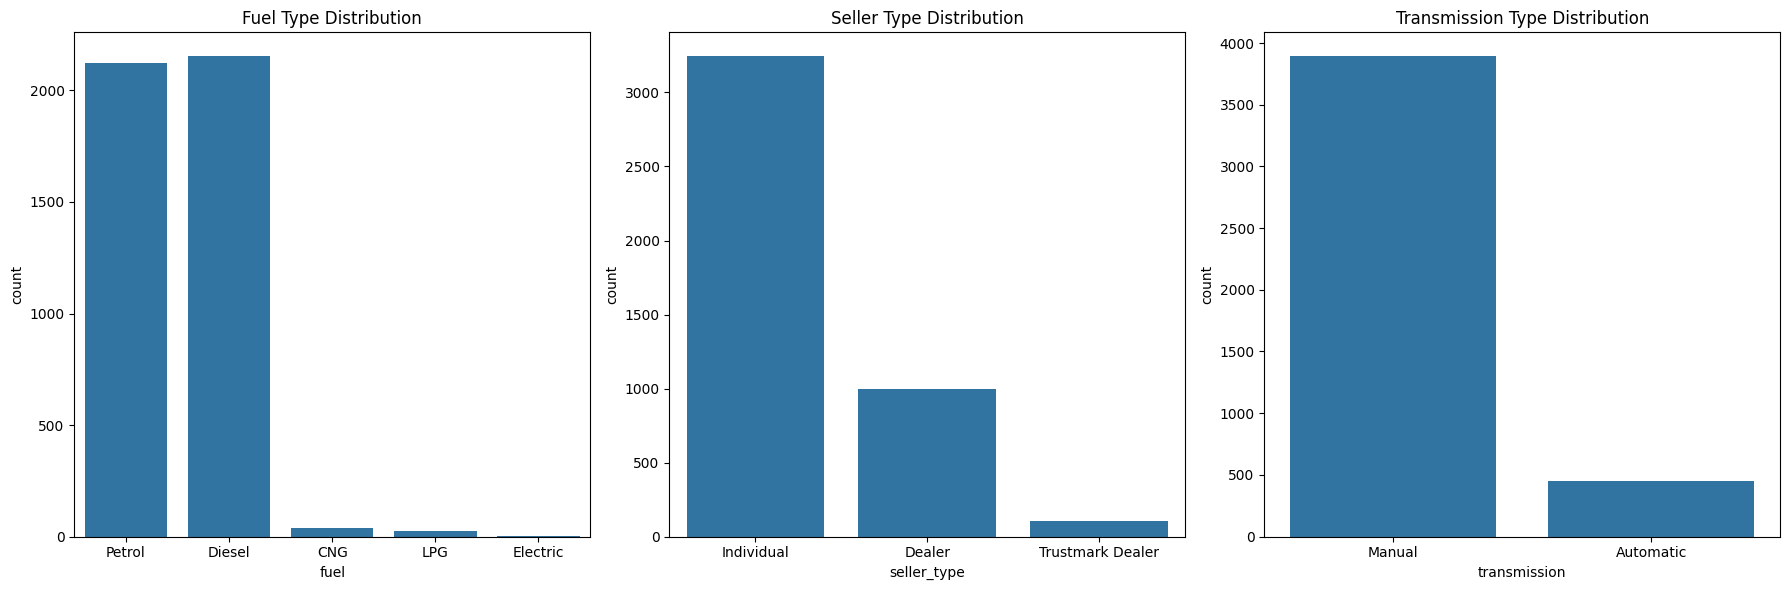

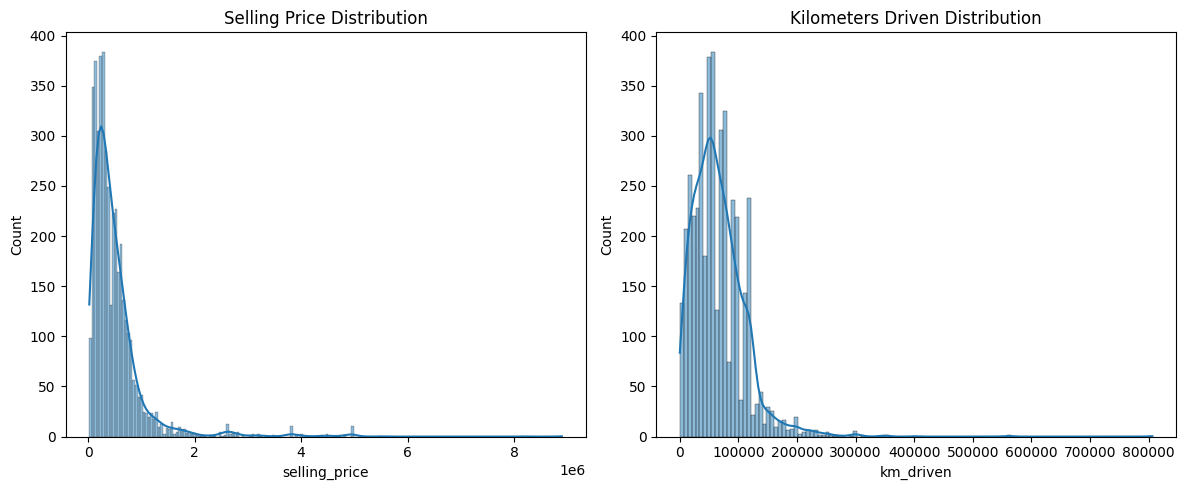

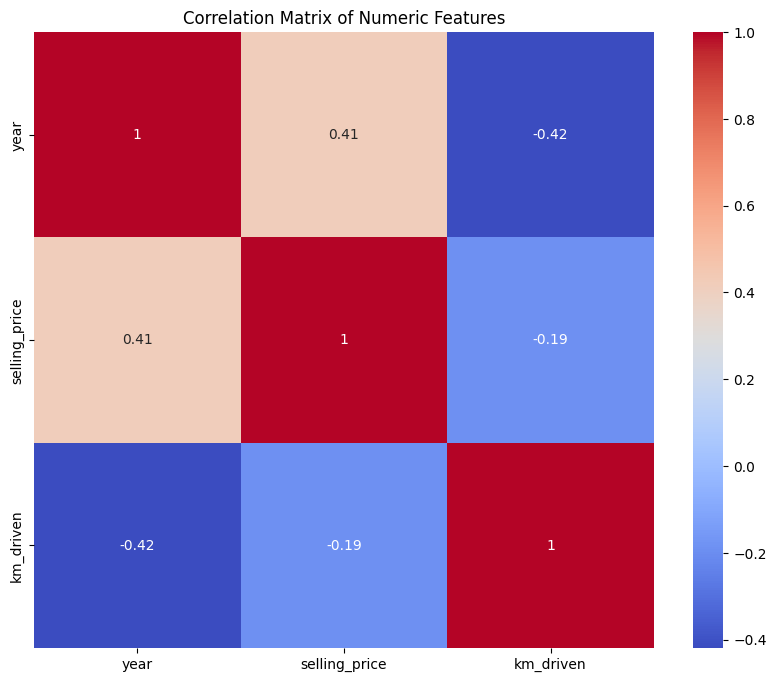

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('CAR DETAILS FROM CAR DEKHO.csv')

# Preview data
print(data.head())
print(data.info())

# 1a. Count plots for categorical variables
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.countplot(x='fuel', data=data)
plt.title('Fuel Type Distribution')

plt.subplot(1, 3, 2)
sns.countplot(x='seller_type', data=data)
plt.title('Seller Type Distribution')

plt.subplot(1, 3, 3)
sns.countplot(x='transmission', data=data)
plt.title('Transmission Type Distribution')

plt.tight_layout()
plt.show()

# 1b. Histograms for continuous variables
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data['selling_price'], kde=True)
plt.title('Selling Price Distribution')

plt.subplot(1, 2, 2)
sns.histplot(data['km_driven'], kde=True)
plt.title('Kilometers Driven Distribution')

plt.tight_layout()
plt.show()

# 1c. Correlation Matrix
# Ensure only numeric data is passed to corr()
numeric_data = data.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()



=== Simple Linear Regression ===
                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     896.9
Date:                Thu, 08 May 2025   Prob (F-statistic):          2.72e-179
Time:                        01:53:10   Log-Likelihood:                -63334.
No. Observations:                4340   AIC:                         1.267e+05
Df Residuals:                    4338   BIC:                         1.267e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     5

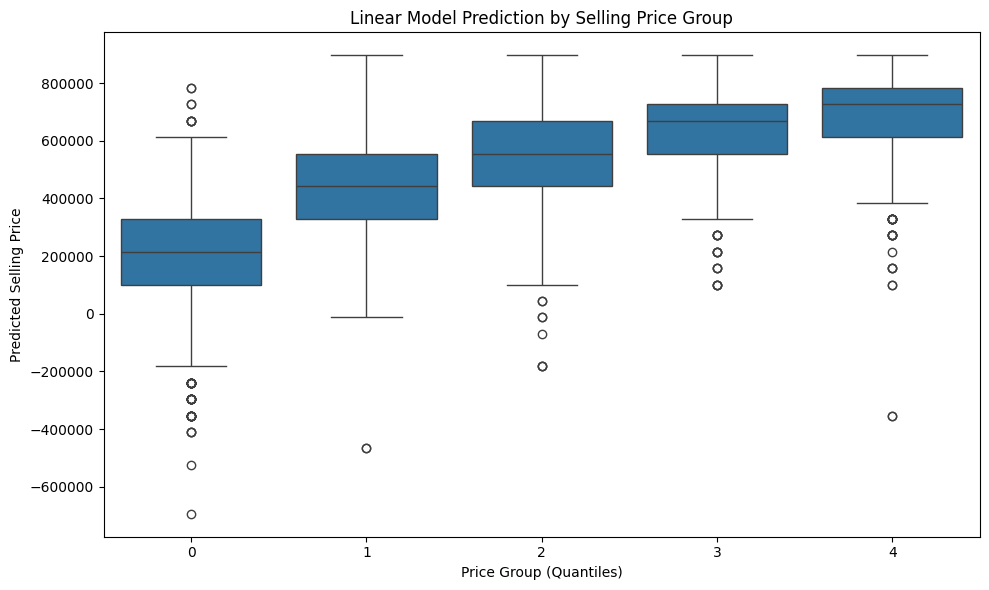

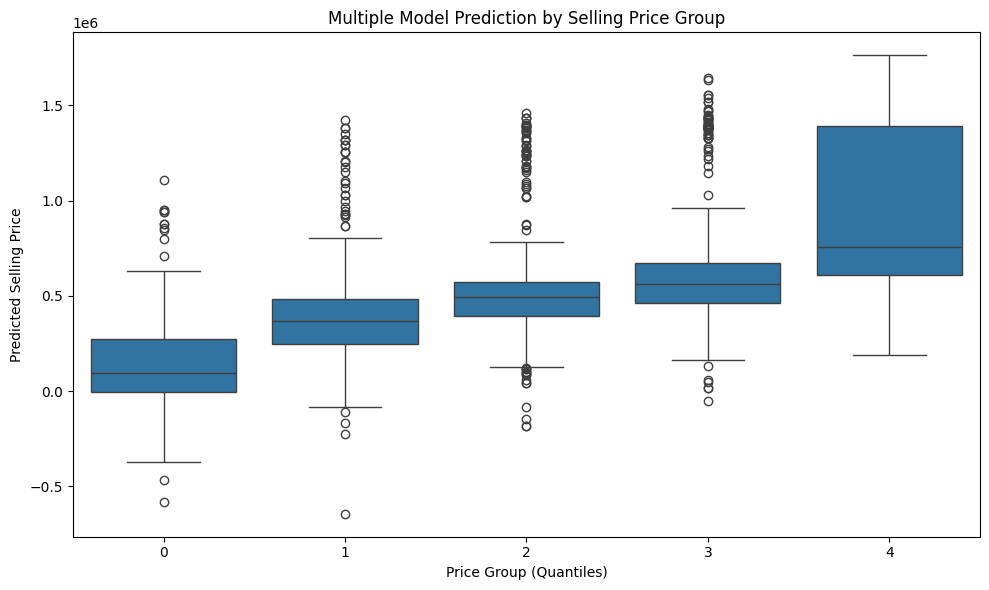

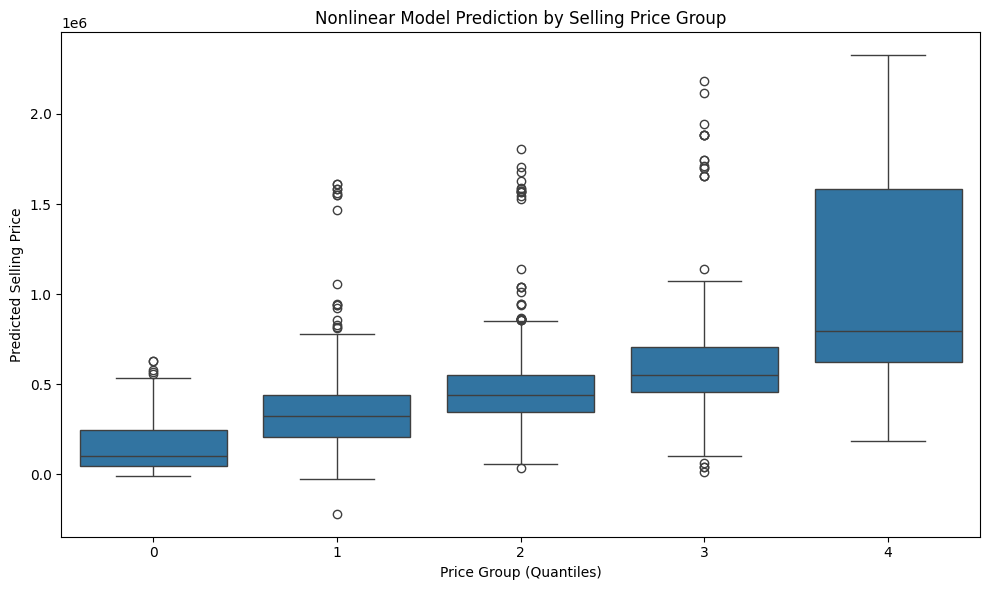

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

# Load dataset
data = pd.read_csv('CAR DETAILS FROM CAR DEKHO.csv')

# Create new feature: car age
data['car_age'] = 2025 - data['year']

# Normalize continuous variables
data['km_driven_norm'] = (data['km_driven'] - data['km_driven'].mean()) / data['km_driven'].std()
data['car_age_norm'] = (data['car_age'] - data['car_age'].mean()) / data['car_age'].std()

# Encode categorical variables
data['fuel_code'] = data['fuel'].astype('category').cat.codes
data['transmission_code'] = data['transmission'].astype('category').cat.codes
data['seller_type_code'] = data['seller_type'].astype('category').cat.codes

# 2a. Simple Linear Regression: selling_price ~ car_age_norm
model_linear = sm.ols('selling_price ~ car_age_norm', data=data).fit()
print("=== Simple Linear Regression ===")
print(model_linear.summary())

# 2b. Multiple Linear Regression
model_multiple = sm.ols(
    'selling_price ~ km_driven_norm + car_age_norm + fuel_code + transmission_code + seller_type_code',
    data=data
).fit()
print("\n=== Multiple Linear Regression ===")
print(model_multiple.summary())

# 2c. Nonlinear Regression with interaction and polynomial terms
model_nonlinear = sm.ols(
    'selling_price ~ km_driven_norm + car_age_norm + fuel_code * transmission_code + np.power(car_age_norm, 2)',
    data=data
).fit()
print("\n=== Nonlinear Regression ===")
print(model_nonlinear.summary())

# Group selling_price into quantile-based categories
data['price_group'] = pd.qcut(data['selling_price'], 5, labels=False)

# Plot predictions for each model
for model, name in zip(
    [model_linear, model_multiple, model_nonlinear],
    ['Linear', 'Multiple', 'Nonlinear']
):
    data['predicted_price'] = model.predict(data)

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='price_group', y='predicted_price', data=data)
    plt.title(f'{name} Model Prediction by Selling Price Group')
    plt.xlabel('Price Group (Quantiles)')
    plt.ylabel('Predicted Selling Price')
    plt.tight_layout()
    plt.show()


In [ ]:
# 3. Thresholded Accuracy Evaluation

def thresholded_accuracy(model, X, y, T):
    y_pred = model.predict(X)
    y_std = np.std(y)
    correct_count = np.sum(np.abs(y_pred - y) <= T * y_std)
    return correct_count / len(y)

# Define features used in each model
X_linear = data[['car_age_norm']]
X_multiple = data[['km_driven_norm', 'car_age_norm', 'fuel_code', 'transmission_code', 'seller_type_code']]
X_nonlinear = data[['km_driven_norm', 'car_age_norm', 'fuel_code', 'transmission_code']].copy()
X_nonlinear['car_age_norm_squared'] = data['car_age_norm'] ** 2
X_nonlinear['fuel_trans_interaction'] = data['fuel_code'] * data['transmission_code']

# Define target variable
y = data['selling_price']

# Threshold values to evaluate
T_values = [0.25, 0.5, 1.0]

# List of models and their corresponding inputs
models = [model_linear, model_multiple, model_nonlinear]
model_names = ['Linear', 'Multiple', 'Nonlinear']
X_values = [X_linear, X_multiple, X_nonlinear]

# Evaluate thresholded accuracy
for model, model_name, X in zip(models, model_names, X_values):
    print(f"\nModel: {model_name}")
    for T in T_values:
        acc = thresholded_accuracy(model, X, y, T)
        print(f"  Thresholded accuracy (T={T}): {acc:.4f}")



Model: Linear
  Thresholded accuracy (T=0.25): 0.4320
  Thresholded accuracy (T=0.5): 0.7300
  Thresholded accuracy (T=1.0): 0.9371

Model: Multiple
  Thresholded accuracy (T=0.25): 0.4993
  Thresholded accuracy (T=0.5): 0.7924
  Thresholded accuracy (T=1.0): 0.9157

Model: Nonlinear
  Thresholded accuracy (T=0.25): 0.5696
  Thresholded accuracy (T=0.5): 0.8272
  Thresholded accuracy (T=1.0): 0.9419


In [ ]:
from sklearn.model_selection import KFold
import numpy as np
import statsmodels.formula.api as sm
import pandas as pd

# Load and prepare the data
data = pd.read_csv('CAR DETAILS FROM CAR DEKHO.csv')
data['car_age'] = 2025 - data['year']
data['km_driven_norm'] = (data['km_driven'] - data['km_driven'].mean()) / data['km_driven'].std()
data['car_age_norm'] = (data['car_age'] - data['car_age'].mean()) / data['car_age'].std()
data['fuel_code'] = data['fuel'].astype('category').cat.codes
data['transmission_code'] = data['transmission'].astype('category').cat.codes
data['seller_type_code'] = data['seller_type'].astype('category').cat.codes

# Define thresholded accuracy function
def thresholded_accuracy(model, X, y, T):
    y_pred = model.predict(X)
    y_std = np.std(y)
    correct_count = np.sum(np.abs(y_pred - y) <= T * y_std)
    return correct_count / len(y)

# Cross-validation setup
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
T_values = [0.25, 0.5, 1.0]

results = {
    'Linear': [],
    'Multiple': [],
    'Nonlinear': []
}

# Perform K-Fold Cross Validation
for train_index, test_index in kf.split(data):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]
    y_train = train_data['selling_price']
    y_test = test_data['selling_price']

    # Prepare input features for each model
    X_linear_test = test_data[['car_age_norm']]
    X_multiple_test = test_data[['km_driven_norm', 'car_age_norm', 'fuel_code', 'transmission_code', 'seller_type_code']]

    X_nonlinear_test = test_data[['km_driven_norm', 'car_age_norm', 'fuel_code', 'transmission_code']].copy()
    X_nonlinear_test['car_age_norm_squared'] = test_data['car_age_norm'] ** 2
    X_nonlinear_test['fuel_trans_interaction'] = test_data['fuel_code'] * test_data['transmission_code']

    # Train models on training set
    model_linear = sm.ols('selling_price ~ car_age_norm', data=train_data).fit()
    model_multiple = sm.ols('selling_price ~ km_driven_norm + car_age_norm + fuel_code + transmission_code + seller_type_code', data=train_data).fit()
    model_nonlinear = sm.ols('selling_price ~ km_driven_norm + car_age_norm + np.power(car_age_norm, 2) + fuel_code * transmission_code', data=train_data).fit()

    for model, model_name, X_test in zip(
        [model_linear, model_multiple, model_nonlinear],
        ['Linear', 'Multiple', 'Nonlinear'],
        [X_linear_test, X_multiple_test, X_nonlinear_test]
    ):
        for T in T_values:
            acc = thresholded_accuracy(model, X_test, y_test, T)
            results[model_name].append(acc)

# Summarize results
for model_name in results:
    print(f"\nModel: {model_name}")
    for T in T_values:
        accuracies = [results[model_name][i] for i in range(len(results[model_name])) if (i % len(T_values)) == T_values.index(T)]
        mean_acc = np.mean(accuracies)
        std_acc = np.std(accuracies)
        print(f"  Thresholded accuracy (T={T}): Mean={mean_acc:.4f}, Std={std_acc:.4f}")



Model: Linear
  Thresholded accuracy (T=0.25): Mean=0.4293, Std=0.0221
  Thresholded accuracy (T=0.5): Mean=0.7325, Std=0.0087
  Thresholded accuracy (T=1.0): Mean=0.9382, Std=0.0060

Model: Multiple
  Thresholded accuracy (T=0.25): Mean=0.4975, Std=0.0209
  Thresholded accuracy (T=0.5): Mean=0.7906, Std=0.0143
  Thresholded accuracy (T=1.0): Mean=0.9157, Std=0.0074

Model: Nonlinear
  Thresholded accuracy (T=0.25): Mean=0.5666, Std=0.0194
  Thresholded accuracy (T=0.5): Mean=0.8235, Std=0.0148
  Thresholded accuracy (T=1.0): Mean=0.9399, Std=0.0076


Epoch [10/100], Loss: 0.1088
Epoch [20/100], Loss: 0.1224
Epoch [30/100], Loss: 0.1251
Epoch [40/100], Loss: 0.1253
Epoch [50/100], Loss: 0.1254
Epoch [60/100], Loss: 0.1254
Epoch [70/100], Loss: 0.1254
Epoch [80/100], Loss: 0.1254
Epoch [90/100], Loss: 0.1254
Epoch [100/100], Loss: 0.1254


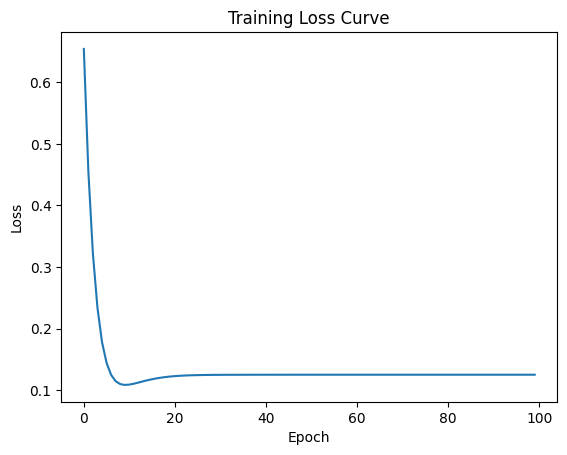

PyTorch Model Evaluation:
RMSE: 430966.03
MAE: 223943.33
R-squared: 0.39


In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
from sklearn.model_selection import KFold

# Load and prepare the data
data = pd.read_csv('CAR DETAILS FROM CAR DEKHO.csv')
data['car_age'] = 2025 - data['year']
data['km_driven_norm'] = (data['km_driven'] - data['km_driven'].mean()) / data['km_driven'].std()
data['car_age_norm'] = (data['car_age'] - data['car_age'].mean()) / data['car_age'].std()
data['fuel_code'] = data['fuel'].astype('category').cat.codes
data['transmission_code'] = data['transmission'].astype('category').cat.codes
data['seller_type_code'] = data['seller_type'].astype('category').cat.codes

# 4. PyTorch Linear Regression Model

# Prepare data for PyTorch
X = data[['km_driven_norm', 'car_age_norm', 'fuel_code', 'transmission_code', 'seller_type_code']].values
y = data['selling_price'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)


# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)


input_dim = X_train.shape[1]
model = LinearRegressionModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Example learning rate

epochs = 100  # Adjust as needed
batch_size = 32
train_losses = []
for epoch in range(epochs):
    for i in range(0, len(X_train_tensor), batch_size):
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

#Plot the loss curve
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

# Evaluate the model
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred = scaler_y.inverse_transform(y_pred.numpy())  # Rescale
    y_test = scaler_y.inverse_transform(y_test) # Rescale
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

print(f"PyTorch Model Evaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R-squared: {r2:.2f}")
